In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from cfe_py.bmi_cfe import BMI_CFE
import os
from cfe_py.fao_pet import FAO_PET

# Read CAMELS data

In [2]:
data_dir = "G:\Shared drives\SI_NextGen_Aridity\dCFE\data"
basin_id = "14301000" #01031500 # 01022500 # 01137500 # 02350900 # 05507600 # 11476600 # 14301000 # 07261000 # 06332515

# Used for ML testing period
start_time= '2013-03-01 00:00:00'
end_time ='2014-02-28 23:00:00'

In [3]:
filename = f"{basin_id}_hourly_nldas.csv"
_forcing_df = pd.read_csv(os.path.join(data_dir, filename))
_forcing_df.set_index(pd.to_datetime(_forcing_df["date"]), inplace=True)
forcing_df = _forcing_df[start_time:end_time].copy()
forcing_df.head()

# # Convert pandas dataframe to PyTorch tensors
# Convert units
# (precip/1000)   # kg/m2/h = mm/h -> m/h
# (pet/1000/3600) # kg/m2/h = mm/h -> m/s
conversions_m_to_mm = 1000
precip =  forcing_df["total_precipitation"].values / conversions_m_to_mm

pet = FAO_PET(nldas_forcing=forcing_df, basin_id=basin_id).calc_PET().values

In [4]:
filename = f"{basin_id}-usgs-hourly.csv"
obs_q_ = pd.read_csv(os.path.join(data_dir, filename))
obs_q_.set_index(pd.to_datetime(obs_q_["date"]), inplace=True)
# obs_q_ = obs_q_["QObs(mm/h)"].values / conversions_m_to_mm
q = obs_q_[start_time:end_time].copy()
q = q["QObs(mm/h)"] / conversions_m_to_mm

# Read default DDS params

In [5]:
best_param_dir = r"G:\Shared drives\SI_NextGen_Aridity\dCFE\data"
file_name = f"cat_{basin_id}_dds_calibrated.json"
with open(os.path.join(best_param_dir,file_name), 'r') as file:
    cfe_params = json.load(file)
cfe_params

{'soil_params': {'depth': 2.0,
  'bb': 6.983631168915888,
  'satdk': 0.0007180945591420005,
  'satpsi': 0.6684009186088888,
  'slop': 1.0,
  'smcmax': 0.21022361269093442,
  'wltsmc': 0.08212173596,
  'D': 2.0,
  'mult': 1000.0},
 'forcing_file': '..\\data\\camels\\gauch_etal_2020\\nldas_hourly\\14301000_hourly_nldas.csv',
 'catchment_area_km2': 1743.54,
 'refkdt': 2.8147222722177783,
 'max_gw_storage': 0.17280700600385382,
 'Cgw': 0.0004867318182786825,
 'expon': 1.5427687982330638,
 'gw_storage': 0.05,
 'alpha_fc': 0.33,
 'K_nash': 0.5651224629023147,
 'K_lf': 0.3610412415070824,
 'nash_storage': [0.0, 0.0],
 'giuh_ordinates': [0.3,
  0.29,
  0.2,
  0.09,
  0.05,
  0.03,
  0.02,
  0.01,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'stand_alone': 1,
 'unit_test': 0,
 'compare_results_file': '',
 'partition_scheme': 'Schaake',
 'soil_scheme': 'classic'}

# Read DDS best params

In [6]:
dds_dir = r"G:\Shared drives\Ryoko and Hilary\cfe_py_camels\dds\results\result-2023-11-30"
filename = f"{basin_id}_bestparams.csv"
with open(os.path.join(dds_dir,filename), 'r') as file:
    dds_params = json.load(file)
dds_params

{'best parameters': {'satdk': 0.04620709761876046,
  'Cgw': 0.020474336746942358},
 'best objective values': [-1.038498373682287]}

# Run CFE simulations

In [7]:
partitioning_scheme = cfe_params['partition_scheme']
soil_scheme = "classic"
cfe_instance = BMI_CFE(cfg_file=os.path.join(best_param_dir,file_name), soil_scheme=soil_scheme, partitioning_scheme=partitioning_scheme)
cfe_instance.stand_alone = 0
synthetic_Cgw = dds_params['best parameters']['Cgw']
synthetic_satdk = dds_params['best parameters']['satdk']
cfe_instance.initialize(Cgw=synthetic_Cgw, satdk=synthetic_satdk)

In [8]:
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for precip_t, pet_t in zip(precip, pet):
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip_t)
    cfe_instance.set_value("water_potential_evaporation_flux", pet_t)
    
    cfe_instance.update()
    
    for output in outputs:
        output_lists[output].append(cfe_instance.get_value(output))
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.3668
    volume input:   1.5224
   volume output:   1.5756
    final volume:   0.3136
        residual: 2.0317e-14

PARTITION MASS BALANCE
    surface runoff:   0.0251
      infiltration:   1.3386
 vol. et from rain:   0.1587
partition residual: 1.4155e-15

GIUH MASS BALANCE
  vol. into giuh:   0.0251
   vol. out giuh:   0.0251
 vol. end giuh q:   0.0000
   giuh residual: 3.1225e-17

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
     init soil vol:   0.2804
    vol. into soil:   1.3386
  vol.soil2latflow:   0.0000
   vol. soil to gw:   0.6129
 vol. et from soil:   0.6925
   final vol. soil:   0.3136
  vol. soil resid.: 1.5543e-15

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0864
       vol to gw:   0.6129
     vol from gw:   0.6994
final gw.storage:   0.0000
    gw.

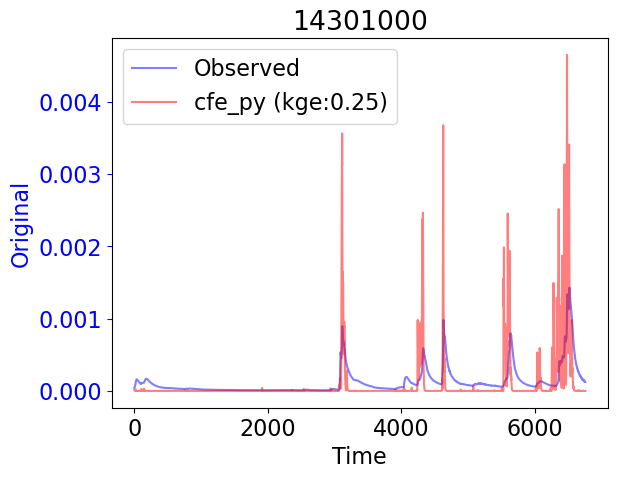

In [10]:
import hydroeval as he
warmup = 2000
fig, ax1 = plt.subplots()
original_data = np.array(output_lists["land_surface_water__runoff_depth"])
x = q.values[warmup:]
y = original_data[warmup:]

# nse = he.nse(x[~np.isnan(x)], y[~np.isnan(x)])
kge = he.kge(x[~np.isnan(x)], y[~np.isnan(x)])
ax1.plot(q.values[warmup:], 'b-', label=f"Observed", alpha=0.5)
ax1.plot(original_data[warmup:], 'r-', label=f"cfe_py (kge:{kge[0][0]:.2f})", alpha=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel(f"Original", color='b')
ax1.tick_params('y', colors='b')
ax1.set_title(basin_id)
ax1.legend()

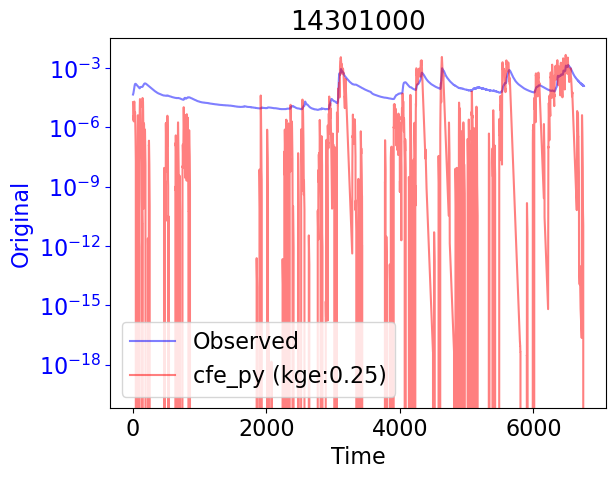

In [11]:
fig, ax1 = plt.subplots()
original_data = output_lists["land_surface_water__runoff_depth"]
ax1.plot(q.values[warmup:], 'b-', label=f"Observed", alpha=0.5)
ax1.plot(original_data[warmup:], 'r-', label=f"cfe_py (kge:{kge[0][0]:.2f})", alpha=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel(f"Original", color='b')
ax1.tick_params('y', colors='b')
ax1.set_yscale('log')
ax1.set_title(basin_id)
ax1.legend()

# Output results

In [18]:
original_data_series = pd.Series(original_data, index=q.index)
out_df = pd.concat([q, original_data_series], axis=1)
out_df.columns = ['y_t', 'y_hat_dds']

# Output the DataFrame to a CSV file
out_df.to_csv(os.path.join(dds_dir, 'combined_data.csv'))
